<a href="https://colab.research.google.com/github/Confirmation-Bias-Analyser/Main-Program/blob/main/Main%20Program%20(Notebook_Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install sentence_transformers
!pip install vaderSentiment
!pip install anytree
!pip install dash
!pip install jupyter-dash
!pip install pyvis

# Import essential libraries and functions

In [2]:
%%capture

from transformers import BertTokenizer, TFBertForSequenceClassification, InputExample, InputFeatures
import pandas as pd
import numpy as np
from google.colab import files
import random
import re

# The shutil module offers a number of high-level operations on files and collections of files.
import os
import shutil

import sys
mainDirectory = "/content/drive/MyDrive/Final Year Project/Key Notebooks/Main Program/"
sys.path.append(mainDirectory + 'Functions/')
from confirmation_bias_model_functions import *
from data_collection_functions import *
from data_preprocessing_functions import *
from visualisation_functions import *
from verification_functions import *

# from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS

from jupyter_dash import JupyterDash
from dash import Dash, html, Input, Output, dash_table, dcc
from dash.dependencies import Input, Output
from IPython.core.display import display, HTML

# Authenticate API keys

In [3]:
with open(mainDirectory + 'twitter_bearer_token.txt', 'r', encoding="utf8") as f:
    token = f.read()

header = create_Twitter_headers(token)

with open(mainDirectory + 'database_uri.txt', 'r', encoding="utf8") as f:
    uri = f.read()

# Data Collection

## Read the data and present as a dataframe

In [4]:
tweets_for_analysis = ['1522931750451617793', '1507922082683793408', '553553331671408641']

for i in range(len(tweets_for_analysis)):
    print(i, tweets_for_analysis[i])

tweetOption = 0 #int(input("Please indicate the tweet to analyse.")) - 1

print(f'\nChosen {tweets_for_analysis[tweetOption]}\n')

if tweetOption == 0 or tweetOption == 1:
    conversationID = tweets_for_analysis[tweetOption]

    query = '''
        select * from comments_for_analysis where conversation_id = '%s'
    '''% conversationID
    
    df = getData(query, uri)

    parent = df['head_id'][0]

    print('About the tweet:')
    print(getSingleTweetInfo(conversationID, header)['data'][0]['text'])

    print('Number of comments:', len(df))

elif tweetOption == 2:
    conversationID = tweets_for_analysis[tweetOption]

    query = '''
        select * from pheme_dataset_for_analysis where head_id = '%s'
    '''% parent

    df = getData(query, uri)

    print('Number of comments:', len(df))

# Create directory to save all results
os.mkdir(tweets_for_analysis[tweetOption])

df['url'] = df['comment'].apply(lambda x: getLinks(x))
df['link_title'] = df['url'].apply(lambda x: getURLfromList(x))
df.head()    

0 1522931750451617793
1 1507922082683793408
2 553553331671408641

Chosen 1522931750451617793

About the tweet:
Over 100 people protest against Covid-19 vaccines with Healing the Divide founder Iris Koh https://t.co/QrY9DhO9sF https://t.co/x1C47MOzUm
Number of comments: 41


,id,timestamp,reply_to,comment,social_media,head_id,conversation_id,user_id,url,link_title
0,10038,2022-05-07T13:40:35.000Z,1619325942,@MothershipSG Why were they not arrested for i...,Twitter,1619325942,1522931750451617793,1474416398,,
1,10000,2022-05-08T15:09:14.000Z,10038,@zacroix @MothershipSG Is about time for peopl...,Twitter,1619325942,1522931750451617793,1520451553165193216,,
2,10001,2022-05-08T11:36:53.000Z,1619325942,@MothershipSG Lanjiao ah! Healing the divide b...,Twitter,1619325942,1522931750451617793,1348988297205305345,,
3,10002,2022-05-08T11:30:17.000Z,1619325942,@MothershipSG She's a clown,Twitter,1619325942,1522931750451617793,770445136371167232,,
4,10003,2022-05-08T11:21:23.000Z,1619325942,@MothershipSG For every protest in any country...,Twitter,1619325942,1522931750451617793,1516288928047071233,,


In [5]:
# with open(mainDirectory + 'database_uri.txt', 'r', encoding="utf8") as f:
#     uri = f.read()

# socialMedia = ['Reddit', 'Twitter', 'PHEME Dataset']

# for i in range(len(socialMedia)):
#     print(i, socialMedia[i])

# socialMediaOption = 1

# print(f'\nChosen {socialMedia[socialMediaOption]}\n')

# if socialMedia[socialMediaOption] == 'Reddit':
#     parent = 'rmqevj'
#     query = '''
#         select * from reddit_posts_for_analysis where head_id = '%s'
#     '''% parent
#     df = getData(query, uri)
    
# elif socialMedia[socialMediaOption] == 'Twitter':
#     # conversationID = '1522931750451617793'
#     conversationID = '1507922082683793408'

#     query = '''
#         select * from comments_for_analysis where conversation_id = '%s'
#     '''% conversationID
    
#     df = getData(query, uri)

#     parent = df['head_id'][0]

#     print('About the tweet:')
#     print(getSingleTweetInfo(conversationID, header)['data'][0]['text'])

#     print('Number of comments:', len(df))

# elif socialMedia[socialMediaOption] == 'PHEME Dataset':
#     parent = '553553331671408641'
#     query = '''
#         select * from pheme_dataset_for_analysis where head_id = '%s'
#     '''% parent
#     df = getData(query, uri)

# df['url'] = df['comment'].apply(lambda x: getLinks(x))
# df['link_title'] = df['url'].apply(lambda x: getURLfromList(x))
# df.head()

## Construction of tree of comments

In [6]:
root = Node(parent)

input_list = [] 

item_count = df['reply_to'].value_counts().to_dict()

for i in range(len(df['id'].tolist())):
    try:
      if df['id'].loc[i] != df['reply_to'].loc[i]:
          input_list.append((df['id'].loc[i], df['reply_to'].loc[i]))

    except:
      continue

In [7]:
output_dict = make_map(input_list)
createTweetsTree(output_dict[parent], root)

# Sentiment Analysis

In [8]:
pred_sentences = cleanComments(df['comment'])

In [9]:
main_directory = '/content/drive/MyDrive/Final Year Project/Key Notebooks/Main Program/'

tokenizer = BertTokenizer.from_pretrained(main_directory + "subjectivity_tokenizer/")
model = TFBertForSequenceClassification.from_pretrained(main_directory + "saved_subjectivity_model/")

In [10]:
textblob_polarity = []
textblob_subjectivity = []
vader_results = []
vaderCompoundScores = []
model_subjectivity_result = predictFromModel(model, tokenizer, pred_sentences)

for i in pred_sentences:
  result = getSentimentalResults(i)
  textblob_polarity.append(result['textblob_polarity'])
  textblob_subjectivity.append(result['textblob_subjectivity'])
  vader_results.append(result['vader_results'])
  vaderCompoundScores.append(result['vader_compound_scores'])

## Saving of results from sentiment analysis into the same dataframe

In [11]:
df['number_of_links'] = df['link_title'].apply(lambda x: len(x))

# Polarity
df['textblob_polarity'] = textblob_polarity
df['vader_compound_score'] = vaderCompoundScores
df['vader_polarity'] = df['vader_compound_score'].apply(lambda x: polarityDetermination(x))

overall_polarity = []
overall_polarity_scores = {}

for i in range(len(textblob_polarity)):
  overall_polarity.append(definePolarity(textblob_polarity[i], vaderCompoundScores[i]))
  overall_polarity_scores[df['id'][i]] = [textblob_polarity[i], vaderCompoundScores[i]]

df['overall_polarity'] = overall_polarity

# Subjectivity
df['model_subjectivity'] = model_subjectivity_result
df['textblob_subjectivity'] = textblob_subjectivity

overall_subjectivity = []
overall_subjectivity_scores = {}

for i in range(len(model_subjectivity_result)):
  overall_subjectivity.append(defineSubjectivity(model_subjectivity_result[i], textblob_subjectivity[i]))
  overall_subjectivity_scores[df['id'][i]] = [float(model_subjectivity_result[i]), textblob_subjectivity[i]]

df['overall_subjectivity'] = overall_subjectivity

df['vader_sentiment'] = vader_results
df['topic_cluster'] = getClusters(pred_sentences, embedder)

df['potential_bias'] = flagPotentialBias(df)

df.to_csv(f'{tweets_for_analysis[tweetOption]}/sentiment_result.csv', index=False)
df.head()

,id,timestamp,reply_to,comment,social_media,head_id,conversation_id,user_id,url,link_title,...,textblob_polarity,vader_compound_score,vader_polarity,overall_polarity,model_subjectivity,textblob_subjectivity,overall_subjectivity,vader_sentiment,topic_cluster,potential_bias
0,10038,2022-05-07T13:40:35.000Z,1619325942,@MothershipSG Why were they not arrested for i...,Twitter,1619325942,1522931750451617793,1474416398,,,...,-0.500,0.6681,POS,UNKNOWN,0.000876,0.50,OBJECTIVE,"{'neg': 0.0, 'neu': 0.523, 'pos': 0.477}",1,0
1,10000,2022-05-08T15:09:14.000Z,10038,@zacroix @MothershipSG Is about time for peopl...,Twitter,1619325942,1522931750451617793,1520451553165193216,,,...,0.125,-0.4364,NEG,UNKNOWN,0.003720,0.45,OBJECTIVE,"{'neg': 0.121, 'neu': 0.879, 'pos': 0.0}",1,0
2,10001,2022-05-08T11:36:53.000Z,1619325942,@MothershipSG Lanjiao ah! Healing the divide b...,Twitter,1619325942,1522931750451617793,1348988297205305345,,,...,0.500,0.0000,NEU,UNKNOWN,0.003858,0.50,OBJECTIVE,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0}",1,0
3,10002,2022-05-08T11:30:17.000Z,1619325942,@MothershipSG She's a clown,Twitter,1619325942,1522931750451617793,770445136371167232,,,...,0.000,0.0000,NEU,NEU,0.003196,0.00,OBJECTIVE,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0}",1,0
4,10003,2022-05-08T11:21:23.000Z,1619325942,@MothershipSG For every protest in any country...,Twitter,1619325942,1522931750451617793,1516288928047071233,,,...,0.000,-0.2500,NEU,NEU,0.003846,0.00,OBJECTIVE,"{'neg': 0.143, 'neu': 0.857, 'pos': 0.0}",1,0


## Results from sentiment analysis

In [12]:
df[['id','comment','textblob_polarity','vader_compound_score','vader_polarity','model_subjectivity','textblob_subjectivity','topic_cluster','potential_bias']].head()

,id,comment,textblob_polarity,vader_compound_score,vader_polarity,model_subjectivity,textblob_subjectivity,topic_cluster,potential_bias
0,10038,@MothershipSG Why were they not arrested for i...,-0.500,0.6681,POS,0.000876,0.50,1,0
1,10000,@zacroix @MothershipSG Is about time for peopl...,0.125,-0.4364,NEG,0.003720,0.45,1,0
2,10001,@MothershipSG Lanjiao ah! Healing the divide b...,0.500,0.0000,NEU,0.003858,0.50,1,0
3,10002,@MothershipSG She's a clown,0.000,0.0000,NEU,0.003196,0.00,1,0
4,10003,@MothershipSG For every protest in any country...,0.000,-0.2500,NEU,0.003846,0.00,1,0


# Confirmation Bias Analysis

In [13]:
head_thread = parent #input('Enter a comment to look at the replies. ')
conversationDF, conversationTree = traceConversation(df, root, head_thread, False)

In [14]:
print("About the tweet\n")

print("Existence of links:")
checkLink = False

for i in df['link_title']:
    if isinstance(i, list):
        print(i)
        checkLink = False

if checkLink:
    print("No links")

else:
  print("\nThe exact link in the comments:")
  for i in df['url']:
      if len(i) > 0:
          print(i)

About the tweet

Existence of links:
['twitter.com']
['twitter.com']
['t.me']
['twitter.com']
['amp.theguardian.com']

The exact link in the comments:
https://twitter.com/DoctorStone96/status/1523003027195850752/photo/1;
https://twitter.com/xandermateusz/status/1522983062346166272/photo/1;
https://t.me/childcovidvaccineinjuriesuk;
https://twitter.com/Ach1llesHeel/status/1522950563167555590/photo/1;
https://amp.theguardian.com/environment/2022/apr/06/microplastics-found-deep-in-lungs-of-living-people-for-first-time;


In [15]:
print("Conversation Tree")
printGraph(root)

Conversation Tree
1619325942
├── 10038
│   ├── 10000
│   └── 10021
├── 10001
├── 10002
├── 10003
├── 10004
├── 10008
├── 10009
├── 10010
├── 10011
├── 10017
├── 10019
├── 10020
├── 10022
├── 10023
├── 10024
├── 10025
├── 10026
├── 10028
├── 10030
├── 10031
├── 10033
├── 10035
├── 10036
├── 10037
├── 10039
│   └── 10034
└── 10040
    └── 10016


## Results of confirmation bias analysis

In [16]:
print("Confirmation Bias Score for Entire Conversation:", calculateBias(conversationDF))
print("Number of potentially bias comments:", len(conversationDF[conversationDF['potential_bias'] == 1]))

Confirmation Bias Score for Entire Conversation: 0.7714285714285714
Number of potentially bias comments: 11


In [17]:
scoreLists = ['number_of_links', 'vader_compound_score', 'textblob_polarity', 'textblob_subjectivity', 'model_subjectivity', 'overall_subjectivity', 'overall_polarity', 'topic_cluster', 'potential_bias']
df_for_visualisation = conversationDF[['id','timestamp','reply_to','comment'] + scoreLists]

app = JupyterDash(__name__)

app.layout = html.Div([
    html.H4('Conversation'),
    html.P(id='table_out'),
    dash_table.DataTable(
        id='table',
        columns=[{"name": i, "id": i} 
                 for i in ['id'] + scoreLists],
        data=df_for_visualisation.to_dict('records'),
        style_cell={
            'textAlign': 'center',
        },
        style_as_list_view=True,
        style_header=dict(backgroundColor="paleturquoise"),
        style_data=dict(backgroundColor="lavender"),
    ), 
])

@app.callback(
    Output('table_out', 'children'), 
    Input('table', 'active_cell'))

def update_graphs(active_cell):
    if active_cell:
        identifier = df_for_visualisation.iloc[active_cell['row']]['id']
        comment = df_for_visualisation.iloc[active_cell['row']]['comment']

        return f"Selected ID: {identifier}, Comment by user: \"{comment}\"" #, {score}"
    return "Click the table"

app.run_server(mode='inline')#debug=True

<IPython.core.display.Javascript object>

## List of potentially bias comments

In [18]:
for index, row in conversationDF[conversationDF['potential_bias'] == 1].iterrows():
    print(row['id'], row['comment'])

10008 @MothershipSG What is there to protest now no need to trace together u can go anywhere u want too free these people
10011 @MothershipSG Not surprising.
It's this category of people who would vote for Donald Trump and Bombong Marcos.
They would probably declare that Russia's invasion of Ukraine is justified.
They're breathing the wrong air in the wrong country.
10016 @K31thc0m @MothershipSG Oh yeah, I don't need to safe entry to most of not all places... The ship has sailed ATM. Which is probably why the permit was granted in the first place. Ok la now I give you talk.
10017 @MothershipSG Well, lets see what latest research says about vaccine vs Omicron: 💁‍♂️ https://t.co/PY8EbJQS6Y
10019 @MothershipSG What a joke. 100 plus people out of 5.68 million people in Singapore. As if that’s going to make a difference. Blind leading the blind.
10020 @MothershipSG nobody's stopping you https://t.co/Nj2znrlW7w
10022 @MothershipSG "I am healthy I have an immune system" is possibly one of the

# Results Verification

## Get the Replies and Retweets of Potentially Bias Users

In [19]:
replies_retweets_result_str = ""

if tweetOption == 0:
    print("Number of potentially bias users:", len(conversationDF[conversationDF['potential_bias'] == 1]['user_id'].unique()), '\n')

    for i in conversationDF[conversationDF['potential_bias'] == 1]['user_id']:
        allUserTweets = combineTweets([getTweetsLikedByUser(i, header, 100)])

        sub_heading = '*********** ' + i + ' ***********'
        replies_retweets_result_str += sub_heading + '\n'
        print(sub_heading)

        for j in checkForRepliesToNews(allUserTweets):
            print(j)
            replies_retweets_result_str += j + '\n'

        replies_retweets_result_str += '\n'
        print()

elif tweetOption == 1:
    print("Number of potentially bias users:", len(conversationDF[conversationDF['potential_bias'] == 1]['id'].unique()), '\n')

    suspectedBiasUsers = ['CardanoAdonis', 'PLafala', 'Erwin_Dawson', 'Coldcappuccino9', '_5andman_', 'Actarus_dEuphor', 'ResenT___', 'mkggoh', 'slowpokemax']

    for i in suspectedBiasUsers:
        userID = getTwitterUserInfo(i, header)['data'][0]['id']
        allUserTweets = combineTweets([getTweetsByUserID(userID, header, 100)])

        sub_heading = '*********** ' + i + ' ***********'
        replies_retweets_result_str += sub_heading + '\n'
        print(sub_heading)

        for j in checkForRepliesToNews(allUserTweets):            
            print(j)
            replies_retweets_result_str += j + '\n'

        replies_retweets_result_str += '\n'
        print()

Number of potentially bias users: 11 

*********** 1531214377 ***********
@zheng_corinne @MothershipSG If I suspect that she is where she is from, she wouldn't articulate her distaste in such a manner in her own backyard. Perhaps she would remain muted, hence the hyper aggressive display. Then again, that's no excuse for such ugly behaviour. Shame on her!
@MothershipSG See la..govt want us to integrate with foreigners leh...how? only Integrated Bus Interchange maybe la.
泼妇。

*********** 804973086567055360 ***********
For 3 months I've been travelling for a travelogue on SE Asia and its hidden gems. Many stunning places, amazing people and fascinating stories. ASEAN has its problems, but also beauty. Get excited for @ChannelNewsAsia's 5-part doco Tapestry: The Heart of ASEAN 📺 Premiere: 27Feb https://t.co/f6VDbSY7HG
My "studio" for the weekend covering #ShangriLaDialogue @ShangriLaSG #SLD17 join me @ChannelNewsAsia https://t.co/EuLKjlCs2R

*********** 83822931 ***********

*********** 3

In [20]:
with open(f'{tweets_for_analysis[tweetOption]}/replies_and_retweets.txt', 'w') as f:
    f.write(replies_retweets_result_str)

### Get the Liked Tweets by Potentially Bias Users

In [21]:
liked_tweets_result_str = ""

if tweetOption == 0:
    for i in conversationDF[conversationDF['potential_bias'] == 1]['user_id']:
        allUserTweets = combineTweets([getTweetsLikedByUser(i, header, 100)])

        sub_heading = '*********** ' + i + ' ***********'
        liked_tweets_result_str += sub_heading + '\n'
        print(sub_heading)

        for j in checkForRepliesToNews(allUserTweets):
            print(j)
            liked_tweets_result_str += j + '\n'

        liked_tweets_result_str += '\n'
        print()

elif tweetOption == 1:
    for i in suspectedBiasUsers:
        userID = getTwitterUserInfo(i, header)['data'][0]['id']
        allUserTweets = combineTweets([getTweetsLikedByUser(userID, header, 100)])

        sub_heading = '*********** ' + i + ' ***********'
        liked_tweets_result_str += sub_heading + '\n'
        print(sub_heading)

        for j in checkForRepliesToNews(allUserTweets):
            print(j)
            liked_tweets_result_str += j + '\n'

        liked_tweets_result_str += '\n'
        print()

*********** 1531214377 ***********
@zheng_corinne @MothershipSG If I suspect that she is where she is from, she wouldn't articulate her distaste in such a manner in her own backyard. Perhaps she would remain muted, hence the hyper aggressive display. Then again, that's no excuse for such ugly behaviour. Shame on her!
@MothershipSG See la..govt want us to integrate with foreigners leh...how? only Integrated Bus Interchange maybe la.
泼妇。

*********** 804973086567055360 ***********
For 3 months I've been travelling for a travelogue on SE Asia and its hidden gems. Many stunning places, amazing people and fascinating stories. ASEAN has its problems, but also beauty. Get excited for @ChannelNewsAsia's 5-part doco Tapestry: The Heart of ASEAN 📺 Premiere: 27Feb https://t.co/f6VDbSY7HG
My "studio" for the weekend covering #ShangriLaDialogue @ShangriLaSG #SLD17 join me @ChannelNewsAsia https://t.co/EuLKjlCs2R

*********** 83822931 ***********

*********** 3246610436 ***********

*********** 1365

In [22]:
with open(f'{tweets_for_analysis[tweetOption]}/liked_tweets.txt', 'w') as f:
    f.write(liked_tweets_result_str)

# Results Visualisation

## Visualise through graph

In [23]:
# G = createNetworkGraph(conversationTree, head_thread)
polarity_map, subjectivity_map, pb_map = getColourNodes(conversationDF)

In [24]:
net = createInterativeNetworkGraph(conversationTree, head_thread, polarity_map, overall_polarity_scores)
net.show(f'{tweets_for_analysis[tweetOption]}/polarity_scores_graph.html')
print('Polarity Scores')
print('Legend: Green - Positive polarity,', 'Pink - Negative polarity,', 'Yellow - Neutral or Unknown')

display(HTML(f'{tweets_for_analysis[tweetOption]}/polarity_scores_graph.html'))

Polarity Scores
Legend: Green - Positive polarity, Pink - Negative polarity, Yellow - Neutral or Unknown


In [25]:
net = createInterativeNetworkGraph(conversationTree, head_thread, subjectivity_map, overall_subjectivity_scores)
net.show(f'{tweets_for_analysis[tweetOption]}/subjectivity_scores_graph.html')
print('Subjectivity Scores')
print('Legend: Light Grey - Subjective comment,', 'Light Blue - Objective comment,', 'Orange - Unknown')

display(HTML(f'{tweets_for_analysis[tweetOption]}/subjectivity_scores_graph.html'))

Subjectivity Scores
Legend: Light Grey - Subjective comment, Light Blue - Objective comment, Orange - Unknown


In [26]:
net = createInterativeNetworkGraph(conversationTree, head_thread, pb_map, [])
net.show(f'{tweets_for_analysis[tweetOption]}/potential_bias_users_graph.html')
print('Legend: Red - Potential Bias,', 'Black - Potential Unbias')

display(HTML(f'{tweets_for_analysis[tweetOption]}/potential_bias_users_graph.html'))

Legend: Red - Potential Bias, Black - Potential Unbias


## Other additional visualisation

In [27]:
# Let's count the number of tweets by sentiments
sentiment_counts = conversationDF.groupby(['overall_polarity']).size()
print(sentiment_counts)

overall_polarity
NEG         4
NEU        13
POS         4
UNKNOWN     9
dtype: int64


In [28]:
topic_cluster_counts = conversationDF.groupby(['topic_cluster']).size()
print(topic_cluster_counts)

topic_cluster
0     8
1    22
dtype: int64


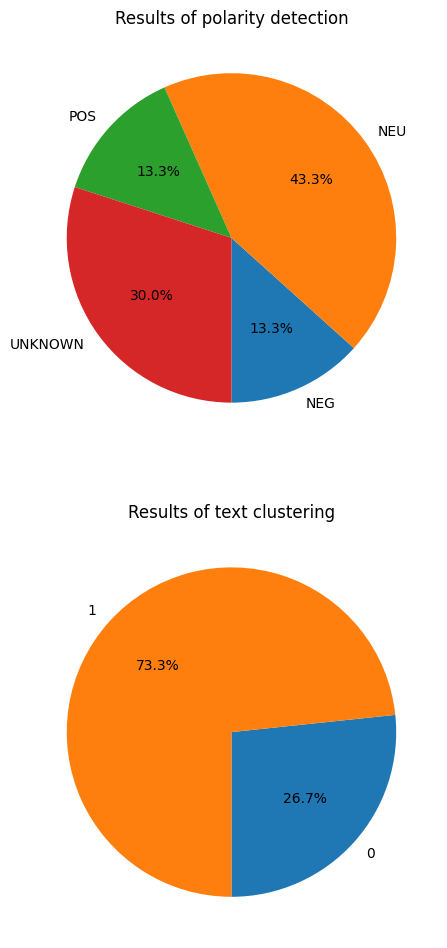

In [29]:
fig = plt.figure(figsize=(12,12), dpi=100)

ax1 = fig.add_subplot(211)
ax1.title.set_text("Results of polarity detection")
ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=270)

ax2 = fig.add_subplot(212)
ax2.title.set_text("Results of text clustering")
ax2.pie(topic_cluster_counts.values, labels=topic_cluster_counts.index, autopct='%1.1f%%', startangle=270)

plt.show()
fig.savefig(f'{tweets_for_analysis[tweetOption]}/pie_charts_polarity_and_text_clustering.png')

In [30]:
# Wordcloud with positive tweets
positive_tweets = []
for i in conversationDF[conversationDF["overall_polarity"] == 'POS']['comment'].tolist():
    positive_tweets.append(re.sub("(@[A-Za-z0-9]+)", "", i))

if len(positive_tweets) != 0:
    stop_words = ["https", "co", "RT"] + list(STOPWORDS)
    positive_wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white", stopwords = stop_words).generate(str(positive_tweets))

# Wordcloud with negative tweets
negative_tweets = []
for i in conversationDF[conversationDF["overall_polarity"] == 'NEG']['comment'].tolist():
    negative_tweets.append(re.sub("(@[A-Za-z0-9]+)", "", i))

if len(negative_tweets) != 0:
    stop_words = ["https", "co", "RT"] + list(STOPWORDS)
    negative_wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white", stopwords = stop_words).generate(str(negative_tweets))

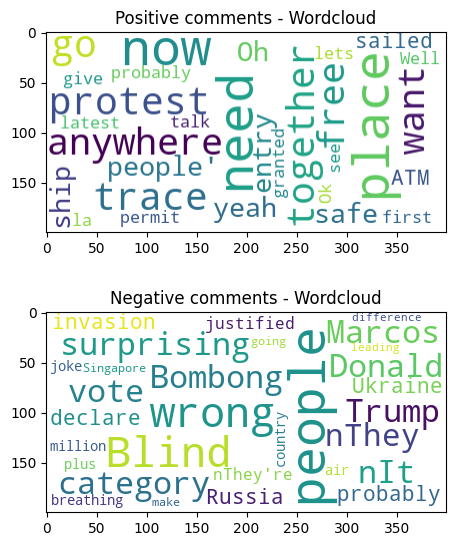

In [31]:
fig = plt.figure(figsize=(6,6), dpi=100)

ax1 = fig.add_subplot(211)
ax1.title.set_text("Positive comments - Wordcloud")
ax1.imshow(positive_wordcloud, interpolation="bilinear")

ax2 = fig.add_subplot(212)
ax2.title.set_text("Negative comments - Wordcloud")
ax2.imshow(negative_wordcloud, interpolation="bilinear")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()
fig.savefig(f'{tweets_for_analysis[tweetOption]}/wordcloud_for_positive_and_negative_sentiments.png')